In [ ]:
#| default_exp imgproc

In [ ]:
%load_ext autoreload
%autoreload 2

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#| include: false
from nbdev.showdoc import *

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/nbconvert/filters/strings.py:22: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  from defusedxml import cElementTree as ElementTree
/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/nbconvert/exporters/html.py:77: DeprecationWarning: 'contextfilter' is renamed to 'pass_context', the old name will be removed in Jinja 3.1.
  def markdown2html(self, context, source):


In [ ]:
#| export 
import torch
import kornia as K
import kornia.geometry as KG
import cv2
import numpy as np

def get_bbox(pts_):
    pts = np.array(pts_).astype(np.int32)
    min_x = pts[:,0].min()
    min_y = pts[:,1].min()
    max_x = pts[:,0].max()
    max_y = pts[:,1].max()
    return min_x,min_y,max_x,max_y

def overlay_common_area(img1, img2, pts1, pts2):
    min_size = min(len(pts1), len(pts2))
    num = min_size
    if min_size < 4:
        return None
    min_x1,min_y1,max_x1,max_y1  = get_bbox(pts1)
    min_x2,min_y2,max_x2,max_y2  = get_bbox(pts2)
    pts1_centered = np.array(pts1[:min_size]) - np.array([min_x1, min_y1])
    pts2_centered = np.array(pts2[:min_size]) - np.array([min_x2, min_y2])

    H, inliers = cv2.findHomography(pts1_centered,
                                    pts2_centered, 0)
    img1_warped = cv2.warpPerspective(img1[min_y1:max_y1, min_x1:max_x1], 
                                      H, 
                                      (max_x2 - min_x2, max_y2-min_y2))
    img1_warped[:,:,0] = img2[min_y2:max_y2, min_x2:max_x2,0] 
    return img1_warped

Function `overlay_common_area` warps the common area, based on the (planar) correspondences between two images, of image 1 into image 2 and replaces one of RGB channels with original image 2.
The warp is perspective warp, defined be the least-squares fit of the correspondences. If some of them are incorrect - bad luck :)
The function is handy to check if the correspondences define a good transformation between images.

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<matplotlib.image.AxesImage>

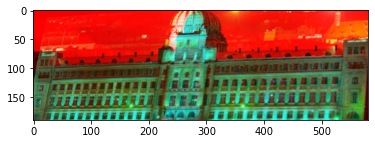

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1_fname = 'sample_project/ministry/01.png'
img2_fname = 'sample_project/ministry/02.png'
c_fname = 'sample_project/ministry/corrs.txt'

img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
corrs = np.loadtxt(c_fname)
overlay = overlay_common_area(img1, img2, corrs[:,:2], corrs[:,2:])
plt.imshow(overlay)

In [ ]:
#| export
import torch
import kornia.feature as KF
import kornia.geometry as KG
from kornia_moons.viz import *

def draw_epipolar_lines(img1, img2, pts1_, pts2_, Fm, ax):
    pts1, pts2, num = clip_corrs(pts1_, pts2_)
    lafs1 = KF.laf_from_center_scale_ori(torch.tensor(pts1).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))
    lafs2 = KF.laf_from_center_scale_ori(torch.tensor(pts2).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))

    idxs = torch.stack([torch.arange(num), torch.arange(num)], dim=-1)
    ax.clear()
    draw_LAF_matches(lafs1, lafs2, idxs, 
                     img1, 
                     img2, 
                     [True for i in range(num)], Fm=Fm.astype(float), ax=ax)
    return

def clip_corrs(pts1, pts2):
    '''Crops out pts1 and pts2 to the smallest common length'''
    min_size = min(len(pts1), len(pts2))
    return pts1[:min_size], pts2[:min_size], min_size

def get_model(pts1_, pts2_, model_type = 'F', leave_idx=None):
    min_model_size = {"F": 8, "H": 4}
    pts1, pts2, min_size = clip_corrs(pts1_, pts2_)
    num = min_size
    if min_size < min_model_size[model_type]:
        return
    corrs = np.concatenate([np.array(pts1)[:min_size],
                            np.array(pts2)[:min_size]], axis=1)
    if leave_idx is not None:
        assert leave_idx <= min_size-1
        assert leave_idx >= 0
        corrs_cur = np.concatenate([
            corrs[:leave_idx],
            corrs[leave_idx+1:]      
        ], axis=0)
    else:
        corrs_cur = corrs
    if model_type == 'F':
        model, inliers = cv2.findFundamentalMat(corrs_cur[:,:2],
                                                corrs_cur[:,2:],
                                                cv2.FM_8POINT)
    elif model_type == 'H':
        model, inliers = cv2.findHomography(corrs_cur[:,:2],
                                            corrs_cur[:,2:],
                                            0)
    else:
        raise ValueError(f" {model} is unknown model type")
    lafs1 = KF.laf_from_center_scale_ori(torch.from_numpy(corrs[:,:2]).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))
    lafs2 = KF.laf_from_center_scale_ori(torch.from_numpy(corrs[:,2:]).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))
    if leave_idx is not None:
        if model_type == 'F':
            err = KG.symmetrical_epipolar_distance(KF.get_laf_center(lafs1[:,leave_idx:leave_idx+1]).view(1,1,2),
                                                   KF.get_laf_center(lafs2[:,leave_idx:leave_idx+1]).view(1,1,2),
                                                   torch.from_numpy(model)[None].float(), squared=False).item()
        elif model_type == 'H':
            err = KG.symmetric_transfer_error(KF.get_laf_center(lafs1[:,leave_idx:leave_idx+1]).view(1,1,2),
                                              KF.get_laf_center(lafs2[:,leave_idx:leave_idx+1]).view(1,1,2),
                                              torch.from_numpy(model)[None].float(), squared=False).item()
        else:
            raise ValueError(f" {model} is unknown model type")
    else:
        err = None
    return model, inliers, err

def draw_homography(img1, img2, pts1_, pts2_, H, ax):
    pts1, pts2, min_size = clip_corrs(pts1_, pts2_)
    num = min_size
    corrs = np.concatenate([np.array(pts1),
                            np.array(pts2)], axis=1)
    lafs1 = KF.laf_from_center_scale_ori(torch.from_numpy(corrs[:,:2]).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))
    lafs2 = KF.laf_from_center_scale_ori(torch.from_numpy(corrs[:,2:]).view(1, -1, 2).float(),
                                         torch.ones(1, num, 1, 1, dtype=torch.float),
                                         torch.zeros(1, num, 1,  dtype=torch.float))
    idxs = torch.stack([torch.arange(min_size), torch.arange(min_size)], dim=-1)
    ax.clear()
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'reprojected_color': (0.2, 0.5, 1),
               'feature_color': None,
               'vertical': False}
    draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, idxs, 
                 img1, 
                 img2, 
                 [True for i in range(min_size)], H=H.astype(float), ax=ax, draw_dict=draw_dict)
    return

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


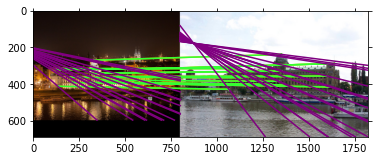

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1_fname = 'sample_project/ministry/01.png'
img2_fname = 'sample_project/ministry/02.png'
c_fname = 'sample_project/ministry/corrs.txt'

img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
corrs = np.loadtxt(c_fname)
F, inliers, err = get_model(corrs[:,:2], corrs[:,2:], 'F')

fig, ax = plt.subplots(1,1)
draw_epipolar_lines(img1, img2, corrs[:,:2], corrs[:,2:], F, ax)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


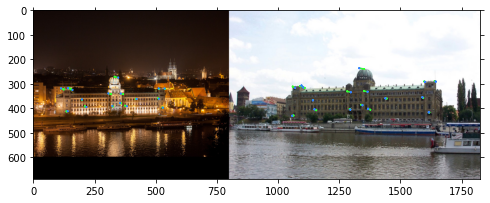

In [ ]:
H, inliers, err = get_model(corrs[:,:2], corrs[:,2:], 'H')
fig, ax = plt.subplots(1,1, figsize=(8,4))
draw_homography(img1, img2, corrs[:,:2], corrs[:,2:], H, ax)


In [ ]:
#| export 
from copy import deepcopy
import math
def tilt_image(img, angle_vert_deg, angle_hor_deg):
    def get_img_corners_bbox(img):
        h,w = img.shape[:2]
        return np.array([[0, 0],
                         [0, h],
                         [w, h],
                         [w, 0]])
    def get_vtilt(h,w, angle_deg = 0.):
        return np.array([[(0 - math.sin(np.deg2rad(angle_deg)))*w/2., 0],
                         [(0 + math.sin(np.deg2rad(angle_deg)))*w/2., h],
                         [(2 - math.sin(np.deg2rad(angle_deg)))*w/2., h],
                         [(2 + math.sin(np.deg2rad(angle_deg)))*w/2., 0]])
    
    def get_htilt(h,w, angle_deg = 0.):
        return np.array([[0, (0 + math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [0, (2 - math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [w, (2 + math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [w, (0 - math.sin(np.deg2rad(angle_deg)))*h/2.]])
    h,w = img.shape[:2]
    new_h, new_w = h,w
    img1 = deepcopy(img)
    orig_4_pts = get_img_corners_bbox(img)
    trans_4_pts = get_vtilt(h, w, angle_vert_deg)
    
    H1 = cv2.getPerspectiveTransform(orig_4_pts.astype(np.float32), trans_4_pts.astype(np.float32))
    new_w, new_h = (int(trans_4_pts[:,0].max()-trans_4_pts[:,0].min()),
                    int(trans_4_pts[:,1].max()-trans_4_pts[:,1].min()))

    new_corners = np.array([[0,0],
                            [0, new_h],
                            [new_w, new_h],
                            [new_w, 0]])
    trans2_4_pts = get_htilt(new_h, new_w, angle_hor_deg)
    
    
    H2 = cv2.getPerspectiveTransform(new_corners.astype(np.float32), trans2_4_pts.astype(np.float32))
    H =  H1 @ H2
    new_corners = cv2.perspectiveTransform(orig_4_pts.reshape(-1,1,2).astype(np.float32), H)[:,0]
    new_w = new_corners[:,0].max()
    new_h = new_corners[:,1].max()
    img_out = cv2.warpPerspective(img, H,  (new_w, new_h))
    return img_out, H, new_w, new_h

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#| export 
from copy import deepcopy
import math
def rectify_plane(img, angle_vert_deg, angle_hor_deg):
    def get_img_corners_bbox(img):
        h,w = img.shape[:2]
        return np.array([[0, 0],
                         [0, h],
                         [w, h],
                         [w, 0]])
    def get_vtilt(h,w, angle_deg = 0.):
        return np.array([[(0 - math.sin(np.deg2rad(angle_deg)))*w/2., 0],
                         [(0 + math.sin(np.deg2rad(angle_deg)))*w/2., h],
                         [(2 - math.sin(np.deg2rad(angle_deg)))*w/2., h],
                         [(2 + math.sin(np.deg2rad(angle_deg)))*w/2., 0]])
    
    def get_htilt(h,w, angle_deg = 0.):
        return np.array([[0, (0 + math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [0, (2 - math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [w, (2 + math.sin(np.deg2rad(angle_deg)))*h/2.],
                         [w, (0 - math.sin(np.deg2rad(angle_deg)))*h/2.]])
    h,w = img.shape[:2]
    new_h, new_w = h,w
    img1 = deepcopy(img)
    orig_4_pts = get_img_corners_bbox(img)
    trans_4_pts = get_vtilt(h, w, angle_vert_deg)
    
    H1 = cv2.getPerspectiveTransform(orig_4_pts.astype(np.float32), trans_4_pts.astype(np.float32))
    new_w, new_h = (int(trans_4_pts[:,0].max()-trans_4_pts[:,0].min()),
                    int(trans_4_pts[:,1].max()-trans_4_pts[:,1].min()))

    new_corners = np.array([[0,0],
                            [0, new_h],
                            [new_w, new_h],
                            [new_w, 0]])
    trans2_4_pts = get_htilt(new_h, new_w, angle_hor_deg)
    
    
    H2 = cv2.getPerspectiveTransform(new_corners.astype(np.float32), trans2_4_pts.astype(np.float32))
    H =  H1 @ H2
    new_corners = cv2.perspectiveTransform(orig_4_pts.reshape(-1,1,2).astype(np.float32), H)[:,0]
    new_w = new_corners[:,0].max()
    new_h = new_corners[:,1].max()
    img_out = cv2.warpPerspective(img, H,  (new_w, new_h))
    return img_out, H, new_w, new_h

This function helps showing tilted version of the images for more convinient labeling

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-88-6830b16fa8e8>:42: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_out = cv2.warpPerspective(img, H,  (new_corners[:,0].max(),
<ipython-input-88-6830b16fa8e8>:42: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_out = cv2.warpPerspective(img, H,  (new_corners[:,0].max(),


<matplotlib.image.AxesImage>

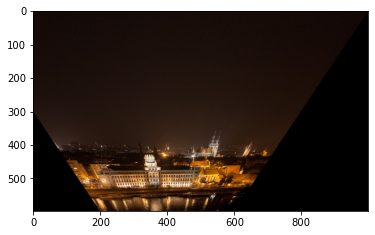

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1_fname = 'sample_project/ministry/01.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

img_tilted, H = tilt_image(img1, 30,0)
plt.imshow(img_tilted)